In [1]:
import scipy.io
import tensorflow as tf
import keras
from numpy import array

from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator

from keras import Model

#build Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D


import pandas as pd
import numpy as np
import seaborn as sns
import missingno as ms
from sklearn import model_selection, metrics  #to include metrics for evaluation # this used to be cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from keras.utils.vis_utils import plot_model

import sys

In [2]:
sys.version_info

sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)

# Data

## Data preparation 

In [2]:
file_path = '/content/drive/MyDrive/Master_AI/DL/data.mat' #@param {type:"string"}

n_length = 58 #@param {type:"slider", min:1, max:100, step:1}
n_batch = 275 #@param {type:"slider", min:0, max:1000, step:1}
shuffel = True #@param {type:"boolean"}

def load_data(path):
  loaded_data = scipy.io.loadmat(file_path)
  dataset = loaded_data['X'] 
  return dataset

def norm_data(dataset):

  normed_data = dataset*1.0
  scale_table = np.zeros((2,5))

  for i in range(5):
    scale_table[0,i] = normed_data[:,:,i].min()
    scale_table[1,i] = normed_data[:,:,i].max()

  scale_table[1] = scale_table[1] - scale_table[0]

  for i in range(5):
    normed_data[:,:,i] = (normed_data[:,:,i] - scale_table[0,i])/scale_table[1,i]

  return normed_data

def split_data(dataset,tv_split=65000,vt_split=69128):
  train_data = dataset[0:tv_split,:,:]
  valid_data = dataset[tv_split:vt_split,:,:]
  test_data = dataset[vt_split:,:,:]
  return train_data, valid_data, test_data

def prep_timeseries(train_data,valid_data,test_data,n_length,n_batch):
  ts_train = TimeseriesGenerator(train_data, train_data[:,3,2], length=n_length, batch_size=n_batch,shuffle=shuffel)
  ts_valid = TimeseriesGenerator(valid_data, valid_data[:,3,2], length=n_length, batch_size=n_batch)
  ts_test = TimeseriesGenerator(test_data, test_data[:,3,2], length=n_length, batch_size=1000)
  return ts_train, ts_valid, ts_test

dataset = load_data(file_path)
normdata = norm_data(dataset)
train_data, valid_data, test_data = split_data(normdata)
ts_train, ts_valid, ts_test = prep_timeseries(train_data,valid_data,test_data,n_length,n_batch)

#plt.plot(normdata[:,:,3])

## Dataset Visualisation

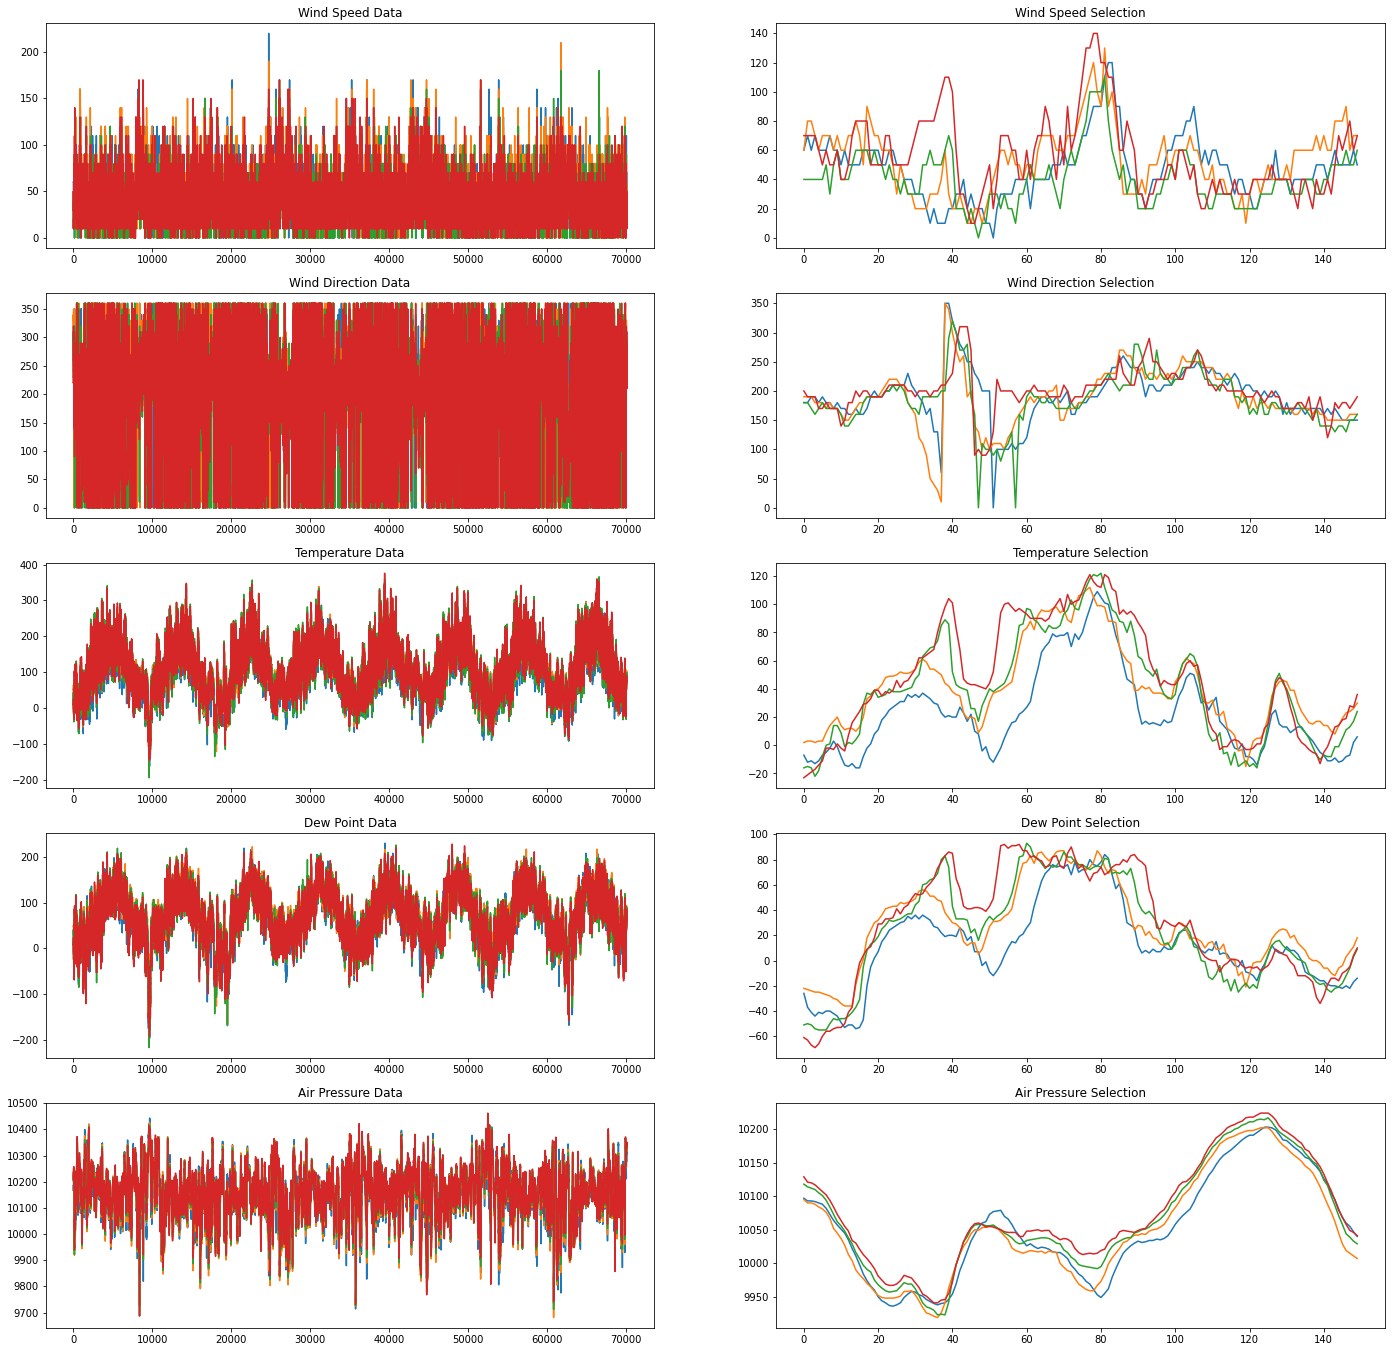

In [12]:
def visulise_data(dataset): 

  labels = ['Wind Speed', 'Wind Direction', 'Temperature', 'Dew Point', 'Air Pressure']

  fig, axs = plt.subplots(5, 2,figsize=(24,24))

  for i in range(5):
    axs[i,0].set_title(labels[i] + ' Data')
    axs[i,0].plot(dataset[:,:,i])
    axs[i,1].set_title(labels[i] + ' Selection')
    axs[i,1].plot(dataset[100:250,:,i])


  plt.show()

visulise_data(dataset)

# Model

In [4]:
from keras import layers

class CNN_Model:

  nn_model = Sequential()
  trained_model = Sequential()
  history = []

  def __init__(self, name, input_shape,autobuild=True,compile=True):
    self.name = name
    self.input_shape = input_shape

    self.nn_model = Sequential()
    self.history = []

    if(autobuild):
      self.setup_input_layer()
      self.conv_layer_group()
      #self.dim_down_layer()
      self.output_layer_block()
    if(compile):
      self.compile_model()

  def __str__(self): 
    return self.name

  def __repr__(self):
    return self.name


  def summary(self): self.nn_model.summary()

  def evaluate(self,test_data): return self.nn_model.evaluate(test_data)

  def conv_layer_group(self,pooling_layer=2):

    self.nn_model.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu'))
    self.nn_model.add(layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu'))
    if(pooling_layer == 1): self.nn_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    if(pooling_layer == 2): self.nn_model.add(layers.AveragePooling2D(pool_size=(2,2)))
    #self.nn_model.add(layers.Conv2D(filters=16, kernel_size=(8,1), activation='relu'))
    #self.nn_model.add(layers.Dropout(.2))

    return 

  def output_layer_block(self,layer_sizes=[128,64,16,1]):
    self.nn_model.add(Flatten())
    for layerS in layer_sizes:
      self.nn_model.add(Dense(layerS))
    return

  def dim_down_layer(self):
    self.nn_model.add(Flatten())
    self.nn_model.add(Dense(128))
    #self.nn_model.add(Dense(64))
    self.nn_model.add(Dense(32))
    #self.nn_model.add(Dense(16))
    self.nn_model.add(Dense(1))
    return 

  def build_model():
    model = models.Sequential()
    return 

  def setup_input_layer(self):
    self.nn_model.add(layers.InputLayer(input_shape=self.input_shape))
    return 

  def compile_model(self):
    self.nn_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=['mse'])#,tf.keras.metrics.RootMeanSquaredError(),'mae'])
    #self.nn_model.compile(optimizer='adam', loss='mse')
    return 

  def fit(self,train,validation,patience=2,MAX_EPOCHS=25,verbose=1):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience, restore_best_weights = True,
                                                    mode='min')

    self.trained_model = self.nn_model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=validation,verbose=verbose,
                      callbacks=[early_stopping])
    
    self.history = self.trained_model.history

    return self.history

n_batch, n_steps, n_cities, n_features = n_batch, n_length, 4, 5

model = CNN_Model("1 Block", (n_steps, n_cities, n_features))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 57, 3, 64)         1344      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 2, 128)        32896     
                                                                 
 average_pooling2d (AverageP  (None, 28, 1, 128)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 128)               458880    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                      

# Training

In [19]:
log = fit_model(model.nn_model,ts_train,ts_valid,5,100)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 57, 3, 64)         1344      
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 2, 128)        32896     
                                                                 
 average_pooling2d_4 (Averag  (None, 28, 1, 128)       0         
 ePooling2D)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 3584)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               458880    
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                     

# Feature Importance

In [26]:
def gradient_importance(seq, model):
    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)
    with tf.GradientTape() as tape:
        predictions = model(seq)
    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def vis_gradient_importance(grads):
  # Define Lable

  labels = ['Wind Speed', 'Wind Direction', 'Temperature', 'Dew Point', 'Air Pressure']

  X = np.arange(len(labels)) 

  # Plot bar chart 

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(X + 0.00, grads[0], color = 'b', width = 0.20, label = 'City A')
  ax.bar(X + 0.20, grads[1], color = 'g', width = 0.20, label = 'City B')
  ax.bar(X + 0.40, grads[2], color = 'r', width = 0.20, label = 'City C')
  ax.bar(X + 0.60, grads[3], color = 'y', width = 0.20, label = 'City D')


  # Add some text for labels,x-axis tick labels

  ax.set_ylabel('Importance')
  ax.set_xlabel('Features')
  ax.set_xticks(X + 0.3)
  ax.set_xticklabels(labels)
  ax.legend()

  plt.show()

In [20]:
def gradient_importance(seq, model):
    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)
    with tf.GradientTape() as tape:
        predictions = model(seq)
    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

data = gradient_importance(ts_test[0][0][0], model.nn_model)
print(data)

[[-0.00032919  0.0003188   0.00042112 -0.00012357  0.00023736]
 [-0.00026189  0.00017331  0.00013307 -0.00053991 -0.00012837]
 [-0.00110566 -0.0007157   0.00710094 -0.00078587 -0.00105289]
 [-0.00063401  0.00015965  0.00975715  0.00044354  0.00053501]]


(4, 5)


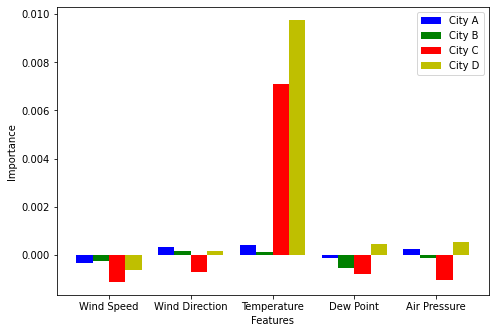

In [21]:
# Define data
print(data.shape)

labels = ['Wind Speed', 'Wind Direction', 'Temperature', 'Dew Point', 'Air Pressure']

X = np.arange(len(labels)) 
#X = X + -0.3
# Plot bar chart 

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.20, label = 'City A')
ax.bar(X + 0.20, data[1], color = 'g', width = 0.20, label = 'City B')
ax.bar(X + 0.40, data[2], color = 'r', width = 0.20, label = 'City C')
ax.bar(X + 0.60, data[3], color = 'y', width = 0.20, label = 'City D')

# text in grouped bar chart



# Add some text for labels,x-axis tick labels

ax.set_ylabel('Importance')
ax.set_xlabel('Features')
ax.set_xticks(X + 0.3)
ax.set_xticklabels(labels)
ax.legend()

# Display plot

plt.show()

# Prediction & Validation

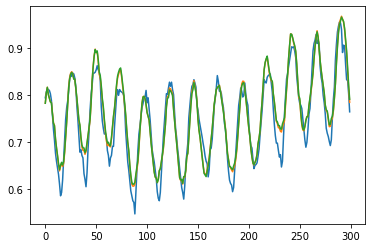

In [ ]:
def ts_prediction(model,data):
  prediction  = model.predict(data, verbose=0)
  return prediction

def rec_predict(model,data,starting_point=0,prediction_length=162):

  prediction_list = np.zeros(prediction_length)
  st_chain = ts_test[0][0][starting_point:(starting_point+1)]

  for i in range(starting_point,prediction_length):
    prediction  = model.predict(st_chain, verbose=0)
    prediction_list[i] = prediction
    st_chain[0] = np.roll(st_chain[0],-1,axis=0)
    new_pred_frame = ts_test[0][0][(i+1):(i+2)]
    new_pred_frame = new_pred_frame[0,-1]
    new_pred_frame[3,2] = prediction 
    st_chain[0,-1] = new_pred_frame

  return prediction_list

nor_pred = ts_prediction(model.nn_model,ts_test)
rec_pred = rec_predict(model.nn_model,ts_test,starting_point=0,prediction_length=300)

plt.plot(ts_test[0][1][0:300])
plt.plot(nor_pred[0:300])
plt.plot(rec_pred)
plt.show()

In [8]:
def ts_prediction(model,data):
  prediction  = model.predict(data, verbose=0)
  return prediction

def ts_recursiv_prediction(model, data):
  prediction_length = data.shape[0]
  recu_prediction = np.zeros(prediction_length-1)
  st_chain = data[:1]
  print(st_chain.shape)

  for i in range(0,prediction_length-1):
    prediction  = model.predict(st_chain, verbose=0)
    recu_prediction[i] = prediction
    st_chain[0] = np.roll(st_chain[0],-1,axis=0)
    new_pred_frame = data[i+1][-1]
    new_pred_frame[3,2] = prediction 
    st_chain[0,-1] = new_pred_frame

  return recu_prediction

def ts_errow_pP(data,norm_prediction,recu_prediction):
  delta_norm = np.absolute(norm_prediction - data)
  delta_recu = np.absolute(recu_prediction - data)
  delta_pred = delta_recu-delta_norm
  return delta_norm,delta_recu,delta_pred


def cross_prediction_validation(model,data,start_point=0,prediction_length=168):

  end_point = (start_point+prediction_length)
  #Cut down data
  preped_data = data[0][0][start_point:end_point]

  true_results = data[0][1][(start_point+0):(end_point-1)]
  norm_prediction = ts_prediction(model,preped_data[:-1])
  recu_prediction = ts_recursiv_prediction(model,preped_data)

  delta_norm,delta_recu,delta_pred = ts_errow_pP(true_results,norm_prediction[:,0],recu_prediction)

  fig, axs = plt.subplots(4, 1,figsize=(24,16), gridspec_kw={'height_ratios': [2, 1, 1,1]})
  axs[0].set_title('Data Prediction')
  axs[0].plot(true_results)
  axs[0].plot(norm_prediction)
  axs[0].plot(recu_prediction)
  axs[1].set_title('Normal Prediction Error')
  axs[1].plot(delta_norm)
  axs[2].set_title('Recursiv Prediction Error')
  axs[2].plot(delta_recu)
  axs[3].set_title('Prediction Error Difference')
  axs[3].axhline(y=0.0, color='r', linestyle='--')
  axs[3].plot(delta_pred)

  print(np.sum(delta_norm))
  print(np.sum(delta_recu))

  return

(1, 58, 4, 5)
1.5178861139952198
2.9354820980603975


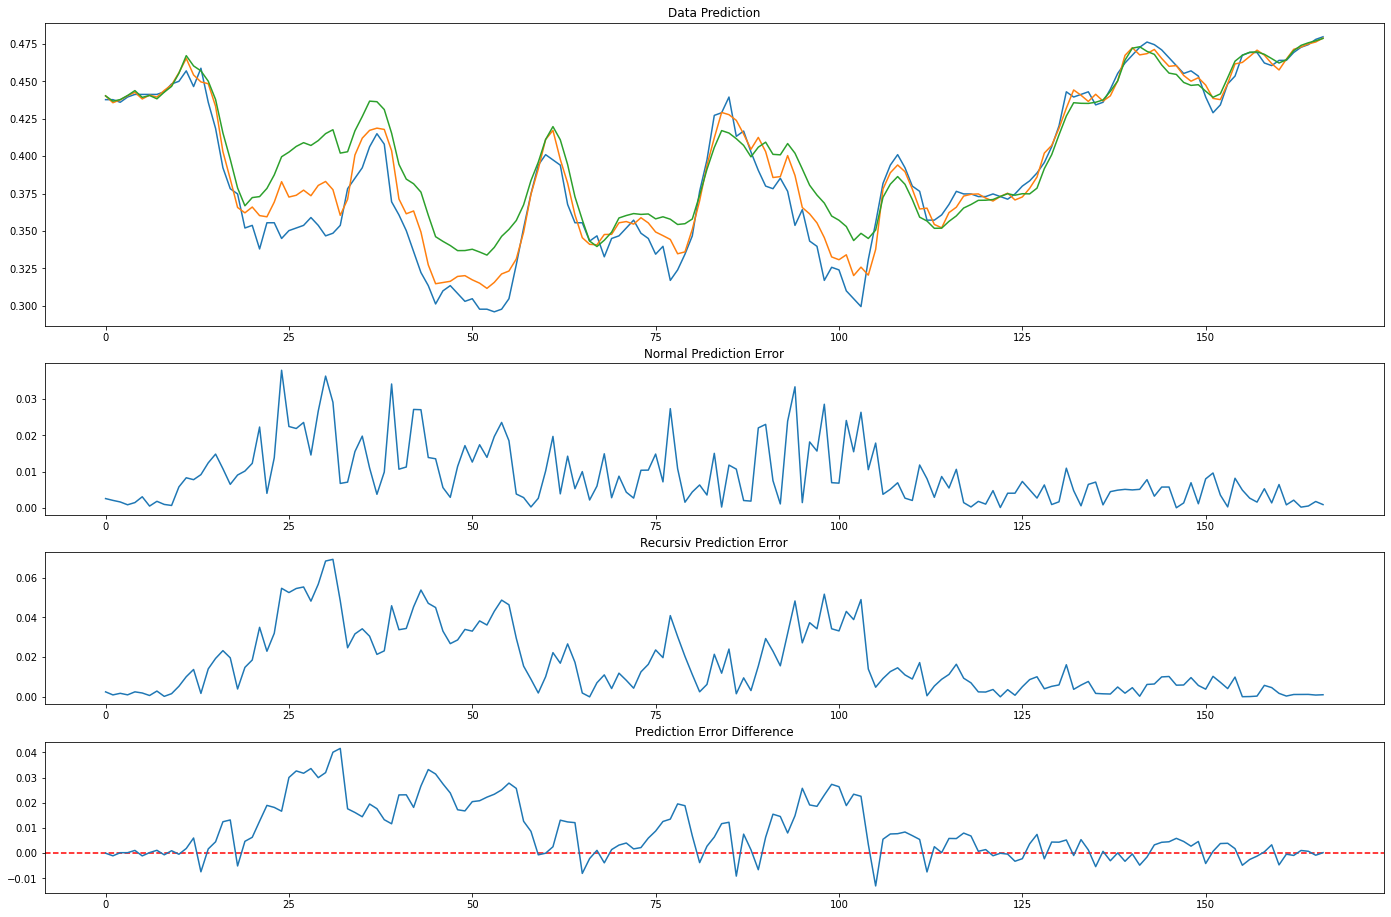

In [22]:
pred = cross_prediction_validation(model.nn_model,ts_test,750)

(1, 58, 4, 5)
1.22085561555029
2.1921909667042634


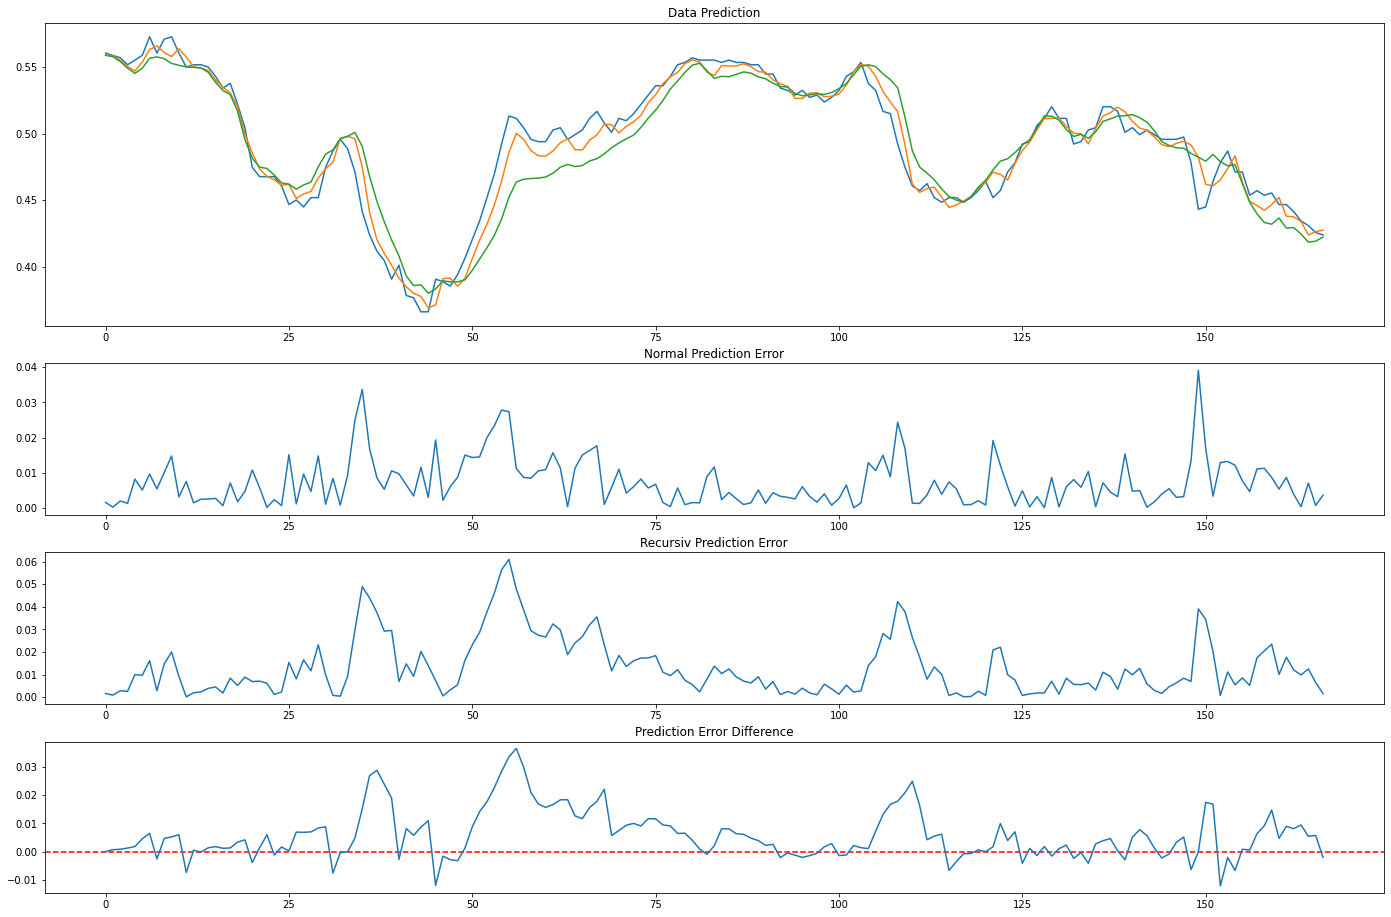

In [23]:
pred = cross_prediction_validation(model.nn_model,ts_test,250)

(1, 58, 4, 5)
2.1173467675253312
3.6301788540521143


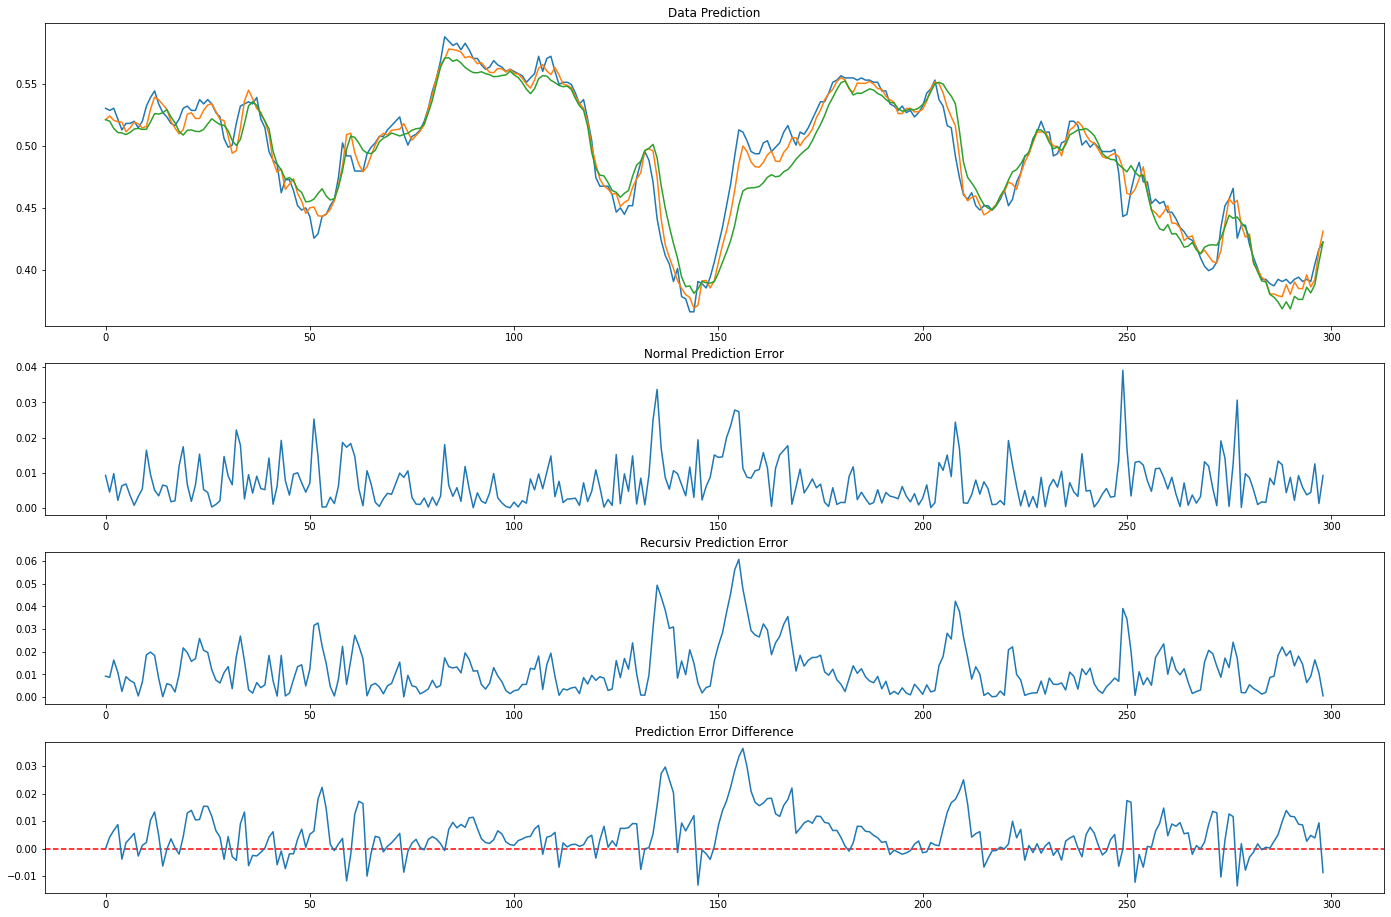

In [24]:
pred = cross_prediction_validation(model.nn_model,ts_test,150,300)

## Old prediction Validation

22.518563631663653
21.901627479916982


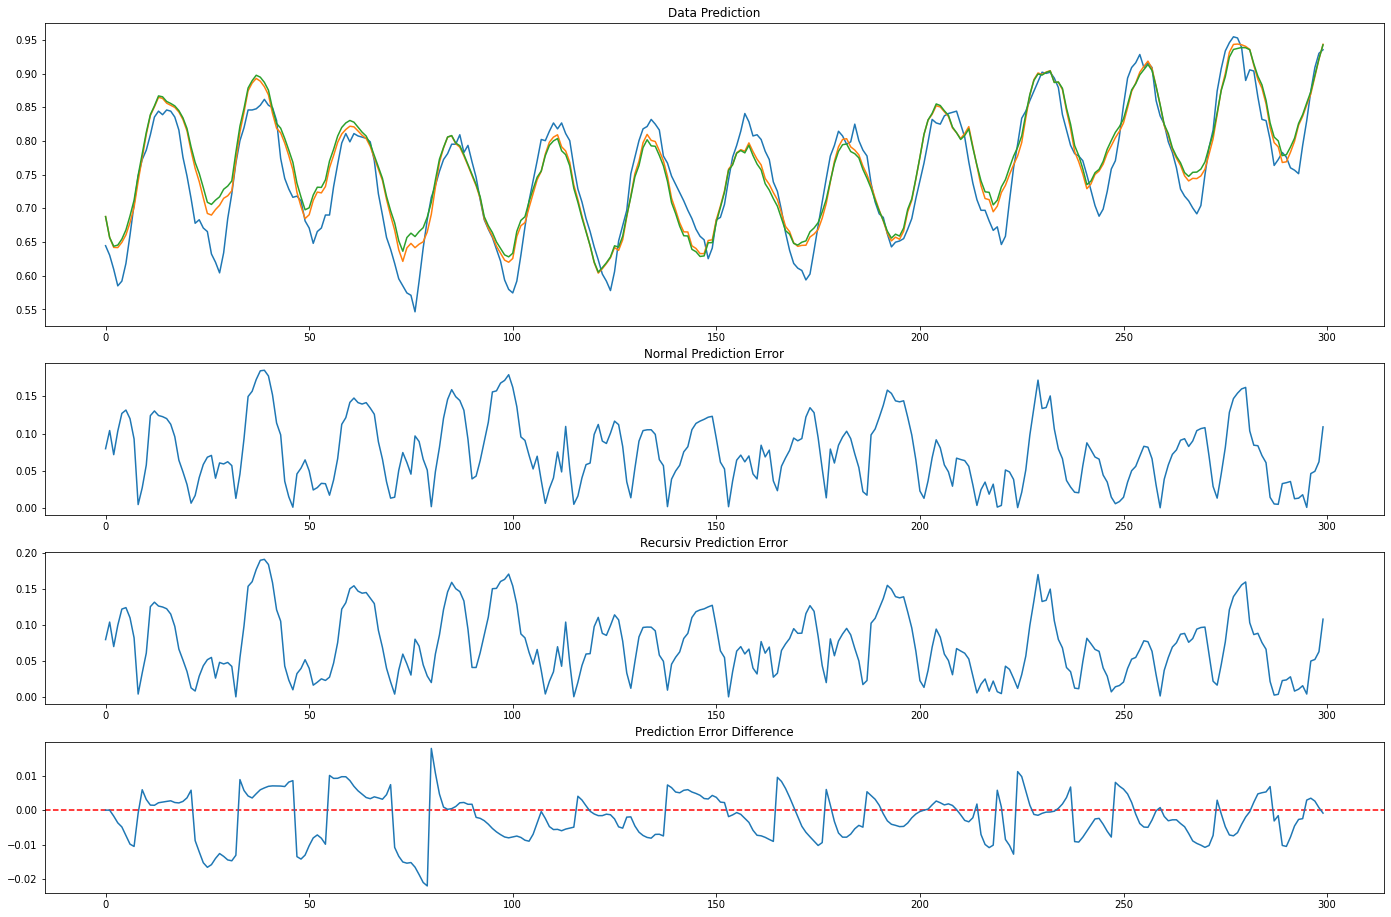

In [26]:
def recursiv_validation(model,data,starting_point=0,prediction_length=162,start_batch = 0):

  end_point = (starting_point+prediction_length)

  d2 = data[start_batch][0]
  d3 = d2[:,0,2,3]

  norm_prediction  = model.predict(d2[starting_point:end_point], verbose=0)

  recu_prediction = np.zeros(prediction_length)
  st_chain = data[start_batch][0][starting_point:(starting_point+1)]

  for i in range(starting_point,prediction_length):
    prediction  = model.predict(st_chain, verbose=0)
    recu_prediction[i] = prediction
    st_chain[0] = np.roll(st_chain[0],-1,axis=0)
    new_pred_frame = data[start_batch][0][(i+1):(i+2)]
    new_pred_frame = new_pred_frame[0,-1]
    new_pred_frame[3,2] = prediction 
    st_chain[0,-1] = new_pred_frame

  n_input = d3.shape[0]-norm_prediction.shape[0]

  delta_norm = np.absolute(norm_prediction[:,0] - d3[:prediction_length])
  delta_recu = np.absolute(recu_prediction[:] - d3[:prediction_length])
  delta_pred = delta_recu-delta_norm


  fig, axs = plt.subplots(4, 1,figsize=(24,16), gridspec_kw={'height_ratios': [2, 1, 1,1]})
  axs[0].set_title('Data Prediction')
  axs[0].plot(data[0][1][0:300])
  axs[0].plot(norm_prediction)
  axs[0].plot(recu_prediction)
  axs[1].set_title('Normal Prediction Error')
  axs[1].plot(delta_norm)
  axs[2].set_title('Recursiv Prediction Error')
  axs[2].plot(delta_recu)
  axs[3].set_title('Prediction Error Difference')
  axs[3].axhline(y=0.0, color='r', linestyle='--')
  axs[3].plot(delta_pred)

  print(np.sum(delta_norm))
  print(np.sum(delta_recu))

  return

recursiv_validation(model.nn_model,ts_test,starting_point=0,prediction_length=300)

(500, 47, 4, 5)
26.442670703801
25.06202650156864


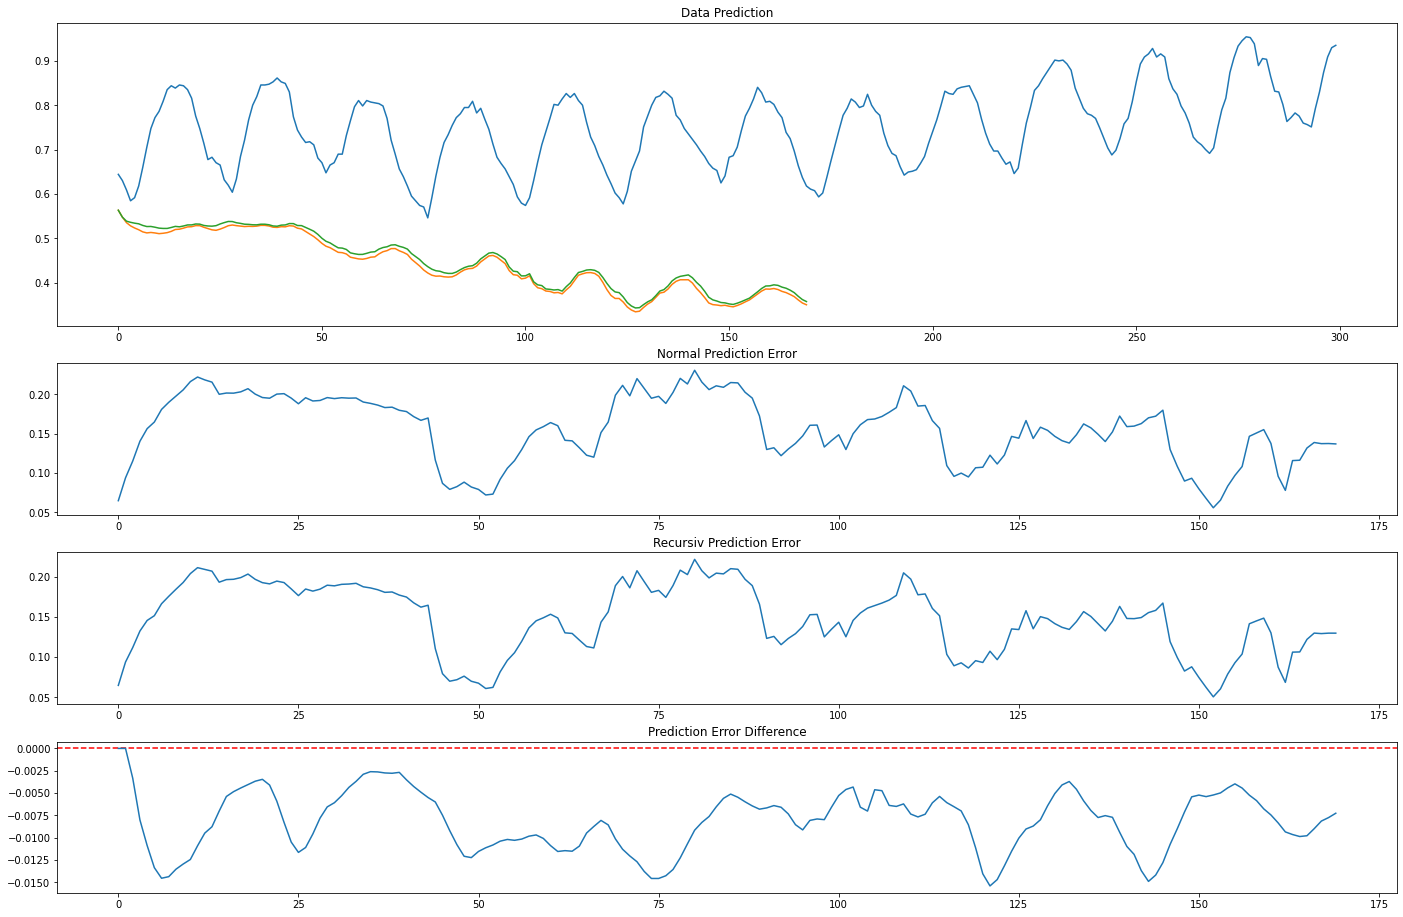

In [27]:
print(ts_test[7][0].shape)
recursiv_validation(model.nn_model,ts_test,prediction_length=170,start_batch=7)

(59953, 1)
(60000,)
47


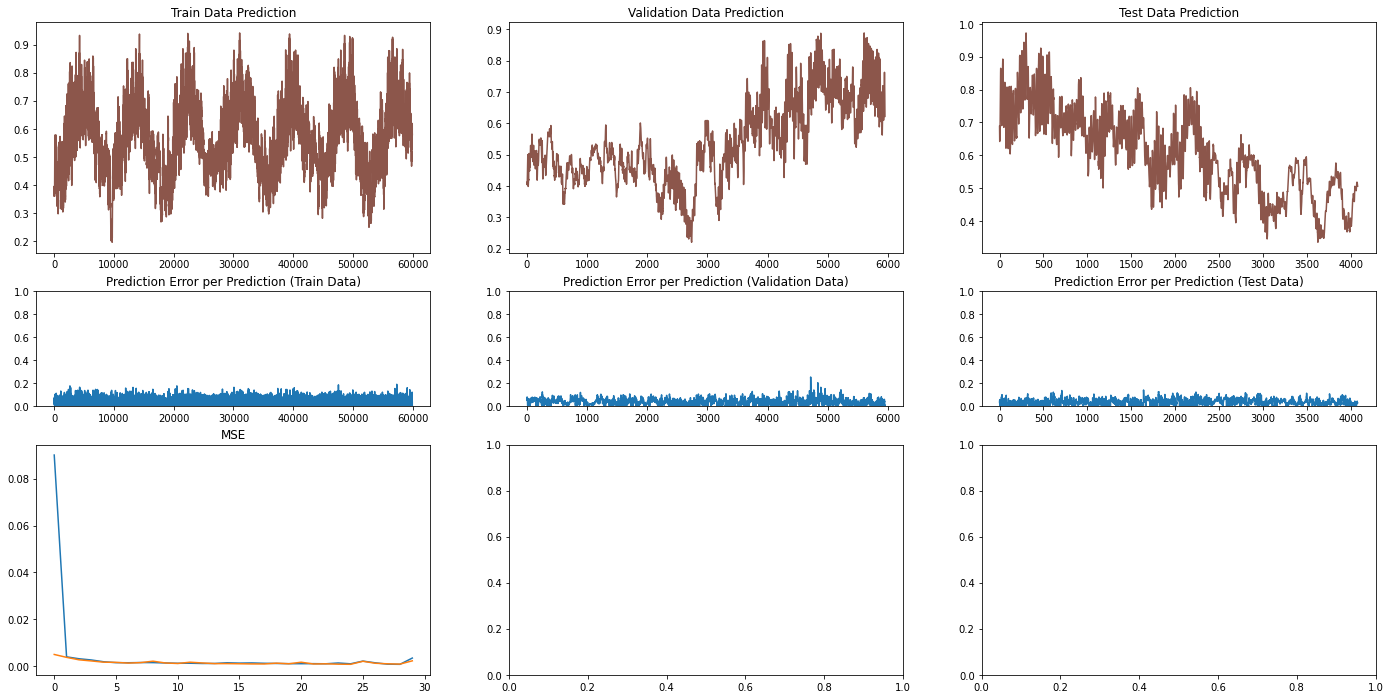

9/9 [==============================] - 1s 71ms/step - loss: 0.0020 - mse: 0.0020
[0.0019750853534787893, 0.0019750853534787893]


In [7]:
def validate_model(model,history,train,validation,test):
  predict_train = model.predict(train, verbose=0)
  predict_valid = model.predict(validation, verbose=0)
  predict_test  = model.predict(test, verbose=0)

  print(predict_train.shape)
  print(train_data[:,3,2].shape)
  print(train_data[:,3,2].shape[0]-predict_train.shape[0])
  n_input = train_data[:,3,2].shape[0]-predict_train.shape[0]
  delta_train = np.absolute(predict_train[:,0]-train_data[n_input:,3,2])
  delta_valid = np.absolute(predict_valid[:,0] - valid_data[n_input:,3,2])
  delta_test = np.absolute(predict_test[:,0] - test_data[n_input:,3,2])

  fig, axs = plt.subplots(3, 3,figsize=(24,12), gridspec_kw={'height_ratios': [2, 1, 2]})
  axs[0,0].set_title('Train Data Prediction')
  axs[0,0].plot(train_data[n_input:3,2])
  axs[0,0].plot(predict_train)
  axs[0,1].set_title('Validation Data Prediction')
  axs[0,1].plot(valid_data[n_input:3,2])
  axs[0,1].plot(predict_valid)
  axs[0,2].set_title('Test Data Prediction')
  axs[0,2].plot(test_data[n_input:3,2])
  axs[0,2].plot(predict_test)

  axs[1,0].set_title('Prediction Error per Prediction (Train Data)')
  axs[1,0].set(ylim=(0.0, 1.0))
  axs[1,0].plot(delta_train)
  axs[1,1].set_title('Prediction Error per Prediction (Validation Data)')
  axs[1,1].set(ylim=(0.0, 1.0))
  axs[1,1].plot(delta_valid)
  axs[1,2].set_title('Prediction Error per Prediction (Test Data)')
  axs[1,2].set(ylim=(0.0, 1.0))
  axs[1,2].plot(delta_test)

  axs[2,0].set_title('MSE')
  axs[2,0].plot(history['mse'])
  axs[2,0].plot(history['val_mse'])
  plt.show()

  results = model.evaluate(test)
  print(results)

  return

validate_model(model.nn_model,model.history,ts_train,ts_valid,ts_test)

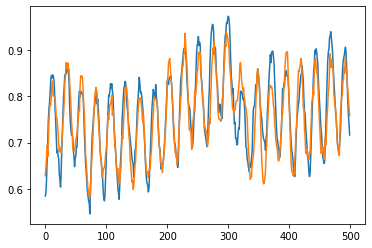

In [ ]:
def ts_prediction(model,data):
  prediction  = model.predict(data, verbose=0)
  return prediction

def ts_recursiv_prediction(model, data, start_data, prediction_length=200):
  prediction = np.zeros(prediction_length)
  temp_predict_data = data
  for i in range(prediction_length):
    recursiv_predict = model.predict(temp_predict_data, verbose=0)
    prediction[i] = recursiv_predict[0,0]
    temp_predict_data = np.roll(temp_predict_data,-1)
    temp_predict_data[0,-1] = recursiv_predict
  return prediction

def ts_errow_pP():
  return misalinement

result_vecs = ts_prediction(model.nn_model,ts_test[0][0])
#rec_results = ts_recursiv_prediction(model.nn_model, ts_test[0][0],ts_test[0][0][1], prediction_length=200)

plt.plot(ts_test[0][1])
plt.plot(result_vecs)
plt.show()

# Time-Step Input Size Optimasation

In [5]:
n_batch, n_steps, n_cities, n_features = n_batch, n_length, 4, 5

#model = CNN_Model("1 Block", (n_steps, n_cities, n_features))

#model.fit(ts_train,ts_valid,3,100)

time_steps = np.arange(10, 101, 1, dtype=int)
models = np.empty(len(time_steps), dtype=CNN_Model)

mse_results = np.empty([3,len(time_steps)])



for i in range(len(time_steps)):
  ts_train, ts_valid, ts_test = prep_timeseries(train_data,valid_data,test_data,time_steps[i],n_batch)
  models[i] = CNN_Model("input_"+str(time_steps[i]), (time_steps[i], n_cities, n_features))
  models[i].fit(ts_train,ts_valid,5,30,verbose=0)
  results = models[i].evaluate(ts_test)

  mse_results[0,i] = models[i].history['mse'][0]
  mse_results[1,i] = models[i].history['val_mse'][0]
  mse_results[2,i] = results[0]



1/1 [==============================] - 0s 233ms/step - loss: 1.3857e-04 - mse: 1.3857e-04


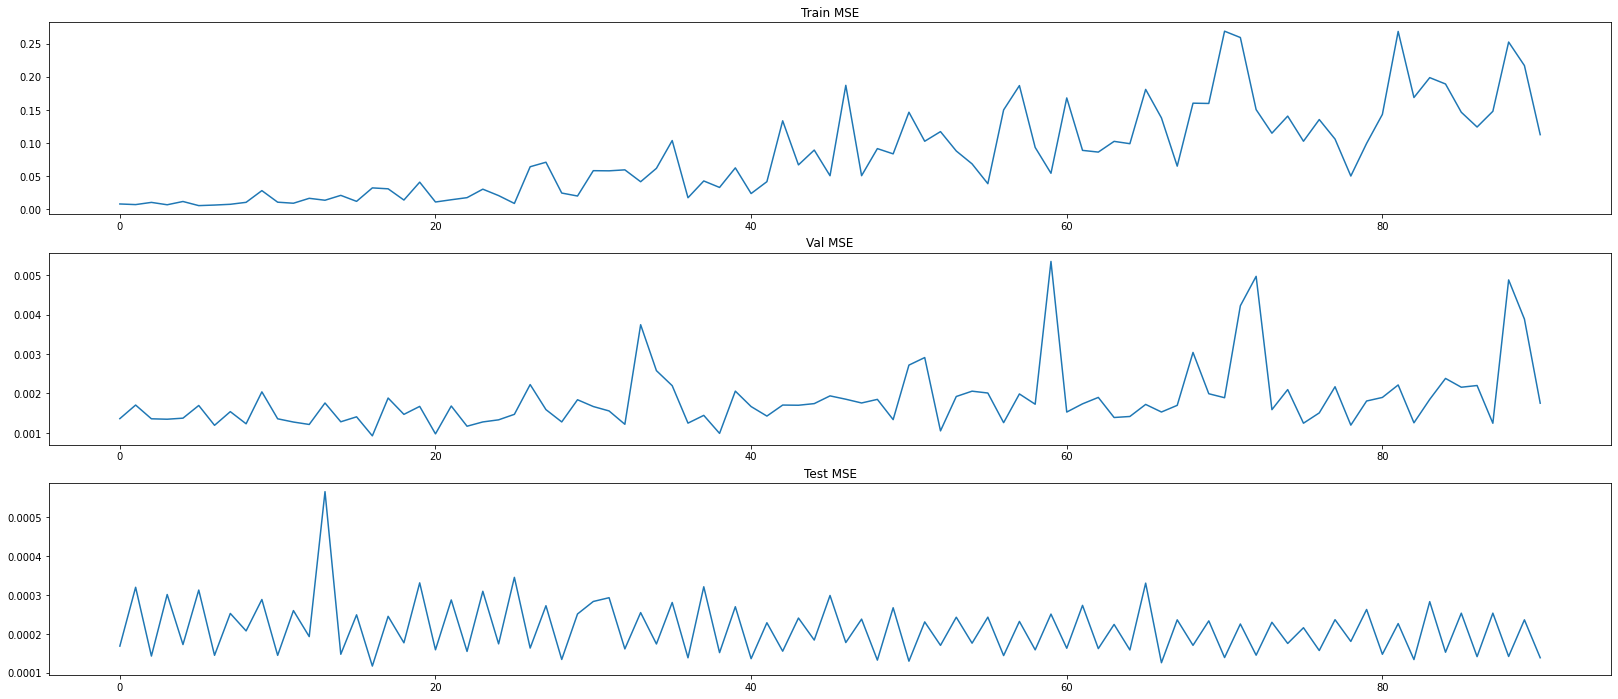

In [6]:
fig, axs = plt.subplots(3, 1,figsize=(28,12))
axs[0].set_title('Train MSE')
axs[0].plot(mse_results[0])
axs[1].set_title('Val MSE')
axs[1].plot(mse_results[1])
axs[2].set_title('Test MSE')
axs[2].plot(mse_results[2])

## Best input size (26) Feature & Prediction Results

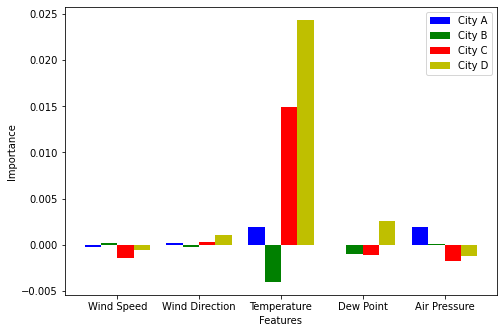

In [27]:
grads = gradient_importance(ts_test[0][0][0], models[16].nn_model)
vis_gradient_importance(grads)

(1, 26, 4, 5)
1.4598666346010516
2.4465551941595223


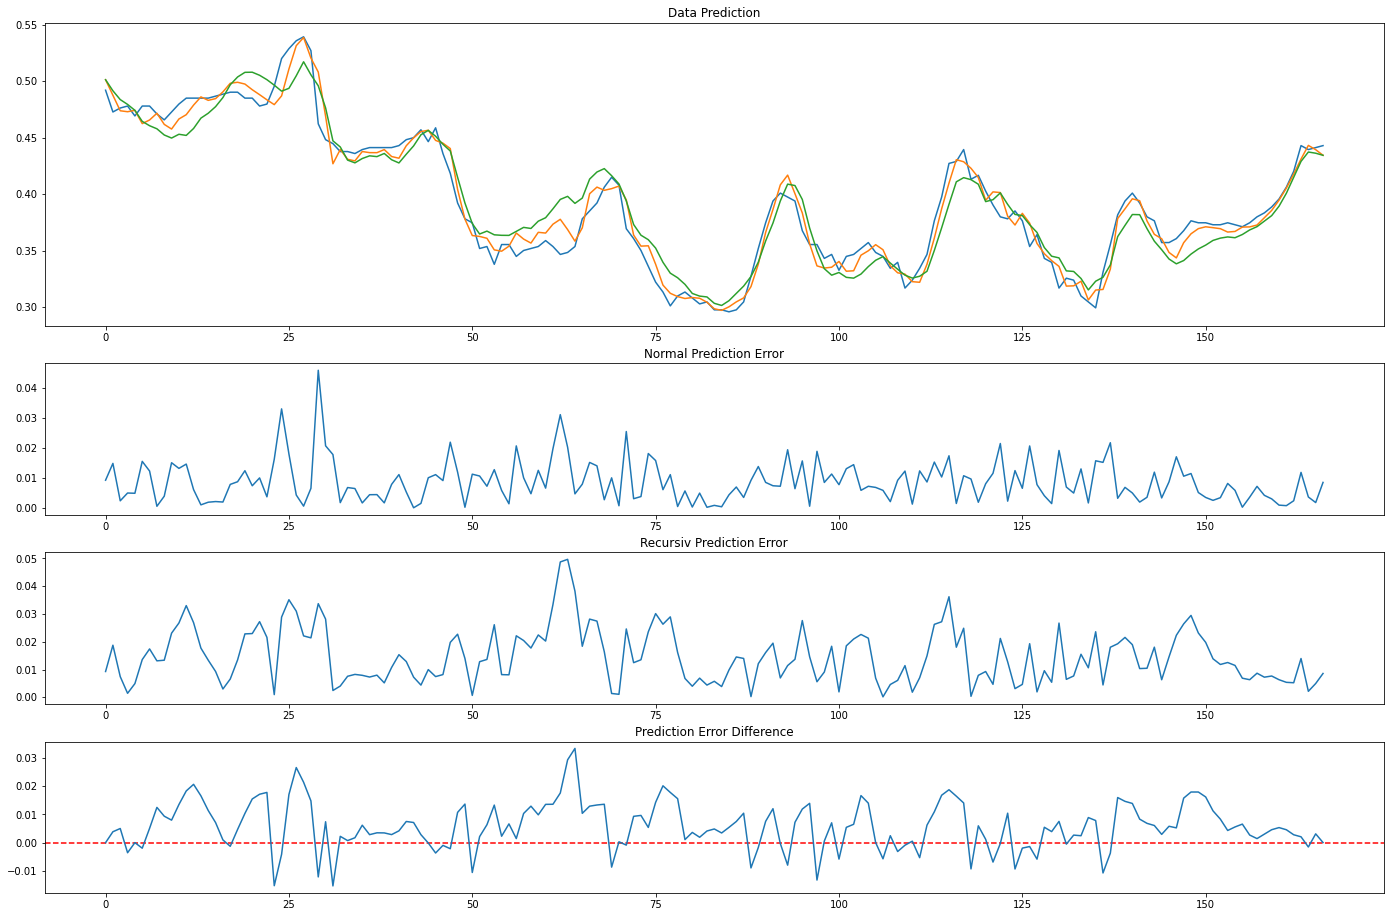

In [18]:
ts_test = TimeseriesGenerator(test_data, test_data[:,3,2], length=26, batch_size=1000)
pred = cross_prediction_validation(models[16].nn_model,ts_test,750)

(1, 26, 4, 5)
1.3625203202985838
2.8295687404697714


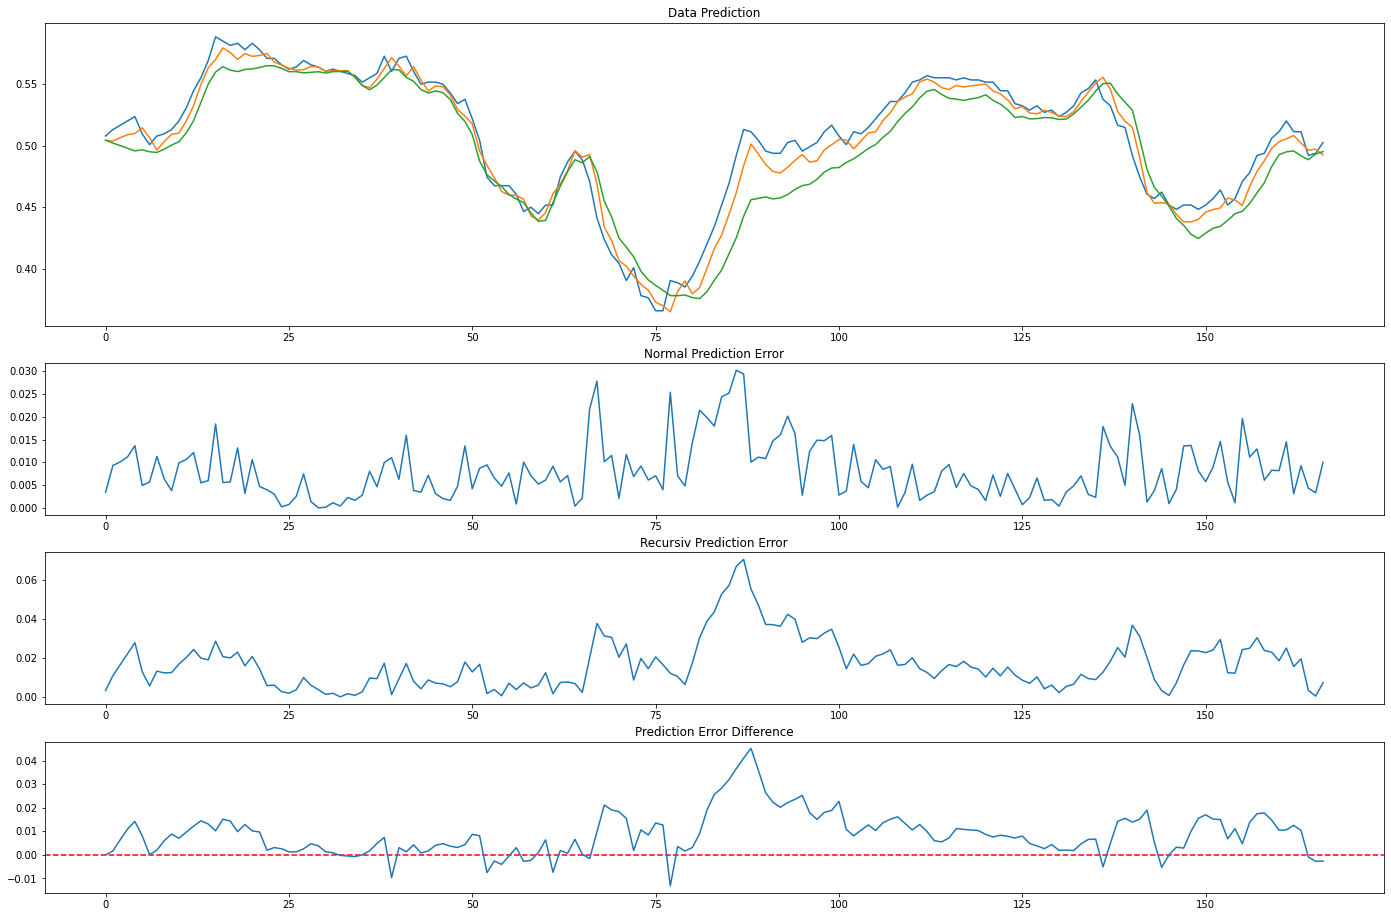

In [20]:
pred = cross_prediction_validation(models[16].nn_model,ts_test,250)

(1, 26, 4, 5)
2.5424947610252167
4.882754191938925


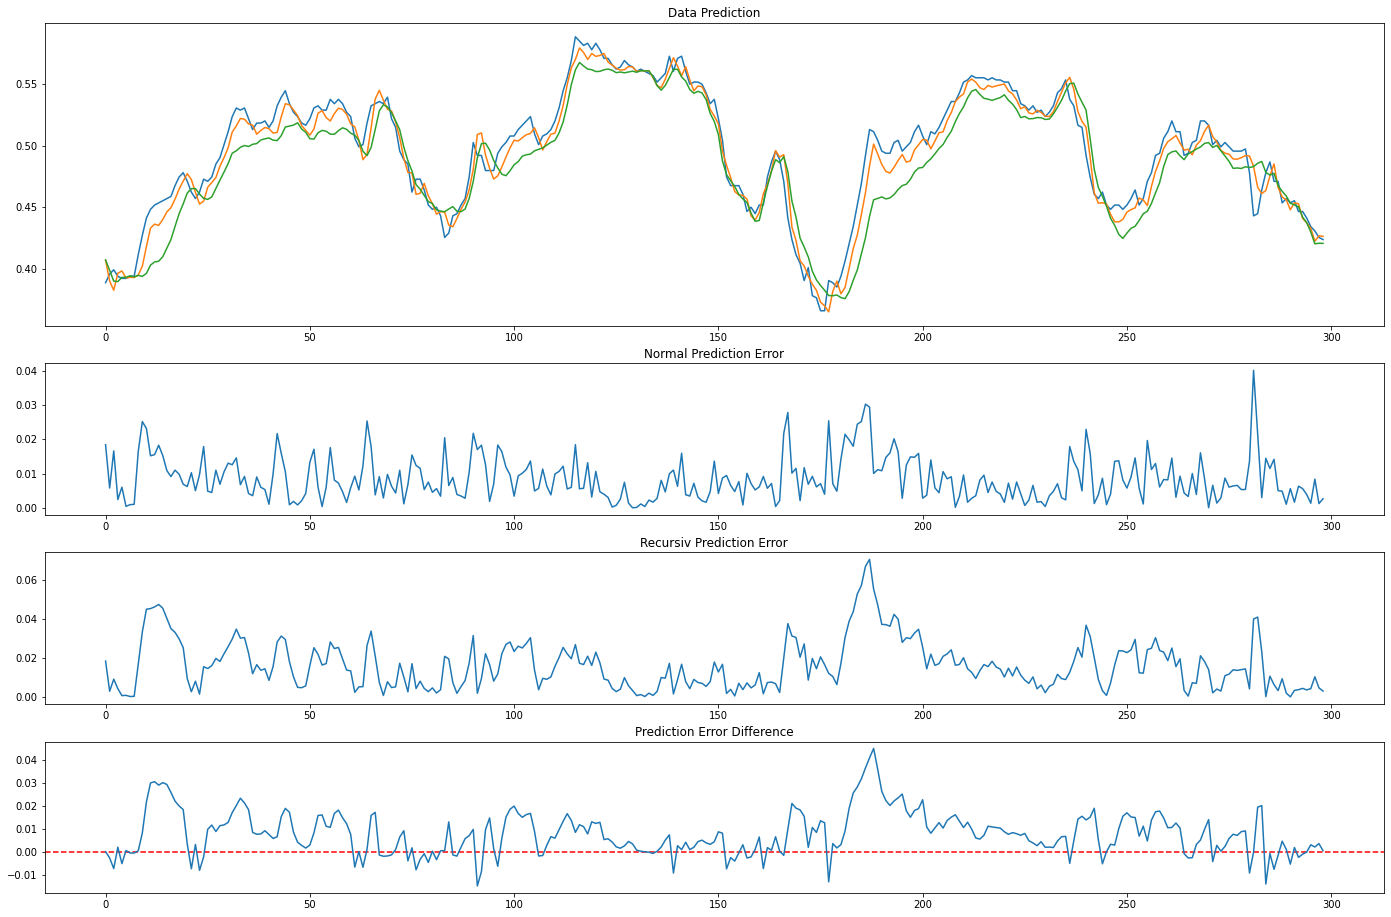

In [21]:
pred = cross_prediction_validation(models[16].nn_model,ts_test,150,300)

## Old input size test results

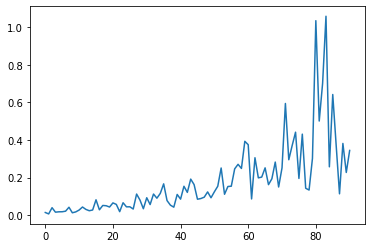

In [ ]:
plt.plot(mse_results[0])

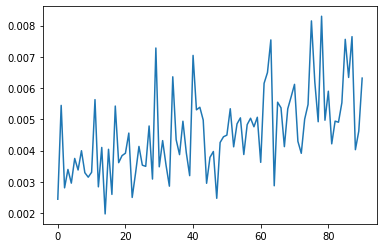

In [ ]:
plt.plot(mse_results[1])

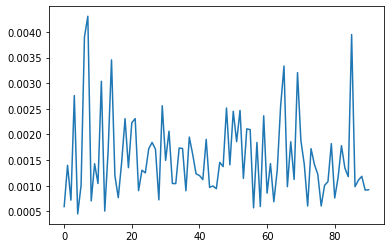

In [ ]:
plt.plot(mse_results[2])

In [ ]:
print(models[i].history['mse'][0])
print(models[i].history['val_mse'][0])
print(results[0])

0.02060456946492195
0.003172942902892828
0.0035805203951895237
